In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import glob
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.spatial.distance import cosine
from scipy import stats
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load and Analyze Spectral Library

Loading spectral library with wavelength data...
Found 401 wavelength bands: 300.0nm to 700.0nm
Materials: ['flower' 'Actinolite_Dolomit' 'Aluminum' 'Ammonium_Chloride'
 'Antigorite+.2DryGrass' 'Antigorite+.33DryGrass' 'Asphalt_Shingle'
 'Brick' 'Calcite.33+Ca-Mont.67' 'Calcite.7+Kaolin-wxl.3'
 'Cordierite-QtzMus' 'Grass_dry.4+.6green' 'Grass_dry.83+.17NaMont'
 'Grass_dry.9+.1green' 'LawnGrass' 'Melting_snow' 'Nylon_Fabric'
 'Nylon_Webbing' 'Oil60_Water40' 'Oil75_Water25' 'Plastic_HDPE' 'Plywood'
 'Polyester_Webbing' 'Polystyrene' 'Potassium_Sulfate'
 'Praseodymium_Chloride_39386' 'Rangeland' 'Sand' 'Sheet_Metal'
 'Sodium_Sulfate' 'Stonewall_Playa' 'Stonwll_Ply+.1grnGrass'
 'Stonwll_Ply+.2grnGrass' 'Strontianite' 'Sulfur' 'Talc+Clinochlore'
 'Teepleite+Trona' 'Terbium_Oxide' 'Terra_Pozzuoli' 'Topaz' 'Tremolite'
 'Trona' 'Ulexite' 'Vermiculite' 'Viridian' 'Water+Montmor' 'Witherite'
 'Wood_Beam' 'WTC_Dust_Debris' 'Xenotime+Monazite_REE' 'Yttrium_Oxide'
 'Zincite+Franklin' 'Zinc_oxide']


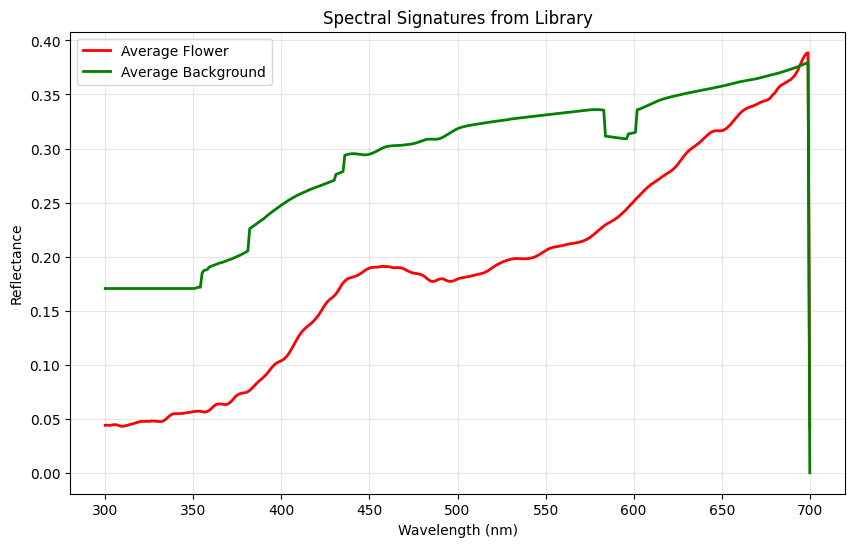

In [2]:
# Spectral library data
print("Loading spectral library with wavelength data...")
speclib = pd.read_csv("../data/csv/spectral_library_classified.csv")

wavelength_cols = [col for col in speclib.columns if col.replace('.','').isdigit() and 300 <= float(col) <= 700]
wavelengths = np.array([float(w) for w in wavelength_cols])

print(f"Found {len(wavelengths)} wavelength bands: {wavelengths[0]}nm to {wavelengths[-1]}nm")
print(f"Materials: {speclib['material'].unique()}")
print(f"Colors: {speclib['colour'].unique()}")

# Separate flower and background spectra
flower_spectra = speclib[speclib['material'] == 'flower']
background_spectra = speclib[speclib['material'] != 'flower']

print(f"\nFlower spectra: {len(flower_spectra)} samples")
print(f"Background spectra: {len(background_spectra)} samples")

# Calculate average spectra
avg_flower_spectrum = flower_spectra[wavelength_cols].mean(axis=0).values
avg_background_spectrum = background_spectra[wavelength_cols].mean(axis=0).values

# Plot spectral signatures
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, avg_flower_spectrum, 'r-', label='Average Flower', linewidth=2)
plt.plot(wavelengths, avg_background_spectrum, 'g-', label='Average Background', linewidth=2)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Spectral Signatures from Library')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 2. Load Aerial Dataset with Coverage Labels

In [3]:
def load_aerial_with_real_coverage():
    """Load aerial images and calculate coverage from bounding boxes"""
    
    base_path = "../data/aerial_dataset"
    print("Loading aerial dataset with coverage labels...")
    
    dataset_data = []
    
    dataset_folders = [
        'active_1', 'active_2', 'active_3', 'active_4', 'active_5',
        'active_6', 'active_7', 'active_8', 'active_9',
        'flower01', 'flower02', 'flower03', 'flower04'
    ]
    
    for folder in dataset_folders:
        images_dir = os.path.join(base_path, folder, 'images')
        labels_dir = os.path.join(base_path, folder, 'labels')
        
        if not os.path.exists(images_dir):
            continue
            
        print(f"  {folder}...")
        
        image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
            image_files.extend(glob.glob(os.path.join(images_dir, ext)))
        
        for img_path in image_files:
            img_name = os.path.splitext(os.path.basename(img_path))[0]
            label_path = os.path.join(labels_dir, img_name + '.txt')
            
            # Calculate coverage from bounding boxes
            coverage = 0.0
            flower_bboxes = []
            
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    lines = f.read().strip().split('\n')
                
                for line in lines:
                    if line.strip():
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            cls, x, y, w, h = map(float, parts[:5])
                            flower_bboxes.append((x, y, w, h))
            
            # Calculate coverage as sum of bbox areas
            total_bbox_area = sum(w * h for x, y, w, h in flower_bboxes)
            coverage = min(1.0, total_bbox_area * 5)  # Reasonable scaling
            
            dataset_data.append({
                'image_path': img_path,
                'folder': folder,
                'coverage': coverage,
                'flower_count': len(flower_bboxes),
                'has_flowers': 1 if len(flower_bboxes) > 0 else 0
            })
    
    df = pd.DataFrame(dataset_data)
    
    print(f"\nDataset Summary:")
    print(f"  Total images: {len(df)}")
    print(f"  Images with flowers: {(df['has_flowers'] == 1).sum()}")
    print(f"  Coverage range: {df['coverage'].min():.3f} to {df['coverage'].max():.3f}")
    
    return df

df_coverage = load_aerial_with_real_coverage()

Loading aerial dataset with coverage labels...
  active_1...
  active_2...
  active_3...
  active_4...
  active_5...
  active_6...
  active_7...
  active_8...
  active_9...
  flower01...
  flower02...
  flower03...
  flower04...

Dataset Summary:
  Total images: 6844
  Images with flowers: 5064
  Coverage range: 0.000 to 0.072


## 3. Extract Physics-Based Spectral Features

In [4]:
def extract_physics_based_features(img_path, flower_spectrum, background_spectrum, wavelengths):
    """Extract physics-based features using spectral matching"""
    try:
        img = Image.open(img_path)
        img_array = np.array(img.convert('RGB')).astype(np.float32) / 255.0
        
        r, g, b = img_array[:,:,0], img_array[:,:,1], img_array[:,:,2]
        
        # Convert RGB to approximate spectral response
        # Simple mapping: R~600nm, G~550nm, B~450nm
        rgb_wavelengths = np.array([600, 550, 450])  # Approximate peaks
        rgb_response = np.array([np.mean(r), np.mean(g), np.mean(b)])
        
        # Interpolate to match spectral library resolution
        from scipy.interpolate import interp1d
        interp_func = interp1d(rgb_wavelengths, rgb_response, kind='linear', 
                              bounds_error=False, fill_value='extrapolate')
        estimated_spectrum = interp_func(wavelengths)
        
        # Normalize spectrum
        estimated_spectrum = (estimated_spectrum - estimated_spectrum.min()) / (estimated_spectrum.max() - estimated_spectrum.min() + 1e-6)
        
        # Calculate spectral matching metrics
        flower_similarity = 1 - cosine(estimated_spectrum, flower_spectrum)
        background_similarity = 1 - cosine(estimated_spectrum, background_spectrum)
        
        # Spectral angle mapper
        def spectral_angle(s1, s2):
            return np.arccos(np.dot(s1, s2) / (np.linalg.norm(s1) * np.linalg.norm(s2) + 1e-6))
        
        flower_angle = spectral_angle(estimated_spectrum, flower_spectrum)
        background_angle = spectral_angle(estimated_spectrum, background_spectrum)
        
        # Calculate spectral indices at key wavelengths
        red_idx = np.argmin(np.abs(wavelengths - 650))  # Red ~650nm
        green_idx = np.argmin(np.abs(wavelengths - 550))  # Green ~550nm
        blue_idx = np.argmin(np.abs(wavelengths - 450))  # Blue ~450nm
        
        red_reflectance = estimated_spectrum[red_idx]
        green_reflectance = estimated_spectrum[green_idx]
        blue_reflectance = estimated_spectrum[blue_idx]
        
        # Physics-based vegetation indices
        ndvi_like = (green_reflectance - red_reflectance) / (green_reflectance + red_reflectance + 1e-6)
        pri = (green_reflectance - red_reflectance) / (green_reflectance + red_reflectance + 1e-6)  # Photochemical Reflectance
        
        # Flower-specific indices based on spectral library
        # Flowers often have high reflectance in green and specific flower-color bands
        flower_color_ratio = green_reflectance / (red_reflectance + 1e-6)
        
        features = {
            # Spectral matching features
            'flower_similarity': max(0, flower_similarity),
            'background_similarity': max(0, background_similarity),
            'flower_angle': flower_angle,
            'background_angle': background_angle,
            'spectral_match_ratio': flower_similarity / (background_similarity + 1e-6),
            
            # Reflectance at key wavelengths
            'reflectance_450nm': blue_reflectance,
            'reflectance_550nm': green_reflectance,
            'reflectance_650nm': red_reflectance,
            
            # Physics-based indices
            'ndvi_like': ndvi_like,
            'pri': pri,
            'flower_color_ratio': flower_color_ratio,
            
            # Spectral shape features
            'spectral_slope': (red_reflectance - blue_reflectance) / (650 - 450 + 1e-6),
            'green_peak_ratio': green_reflectance / ((red_reflectance + blue_reflectance)/2 + 1e-6),
            
            # Additional robust features
            'spectral_entropy': stats.entropy(estimated_spectrum + 1e-6),
            'spectral_variance': np.var(estimated_spectrum)
        }
        
        return features
        
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

# Extract physics-based features
print("\nExtracting physics-based spectral features...")
physics_features = []

for idx, row in df_coverage.iterrows():
    if idx % 50 == 0:
        print(f"  Processed {idx}/{len(df_coverage)} images...")
    
    features = extract_physics_based_features(
        row['image_path'], 
        avg_flower_spectrum, 
        avg_background_spectrum,
        wavelengths
    )
    
    if features is not None:
        features['coverage'] = row['coverage']
        features['flower_count'] = row['flower_count']
        features['image_path'] = row['image_path']
        features['folder'] = row['folder']
        physics_features.append(features)

df_physics = pd.DataFrame(physics_features)
print(f"✓ Extracted physics-based features from {len(df_physics)} images")


Extracting physics-based spectral features...
  Processed 0/6844 images...
  Processed 50/6844 images...
  Processed 100/6844 images...
  Processed 150/6844 images...
  Processed 200/6844 images...
  Processed 250/6844 images...
  Processed 300/6844 images...
  Processed 350/6844 images...
  Processed 400/6844 images...
  Processed 450/6844 images...
  Processed 500/6844 images...
  Processed 550/6844 images...
  Processed 600/6844 images...
  Processed 650/6844 images...
  Processed 700/6844 images...
  Processed 750/6844 images...
  Processed 800/6844 images...
  Processed 850/6844 images...
  Processed 900/6844 images...
  Processed 950/6844 images...
  Processed 1000/6844 images...
  Processed 1050/6844 images...
  Processed 1100/6844 images...
  Processed 1150/6844 images...
  Processed 1200/6844 images...
  Processed 1250/6844 images...
  Processed 1300/6844 images...
  Processed 1350/6844 images...
  Processed 1400/6844 images...
  Processed 1450/6844 images...
  Processed 1500

## 4. Train Physics-Based Coverage Model

In [5]:

feature_cols = [col for col in df_physics.columns if col not in 
                ['coverage', 'flower_count', 'image_path', 'folder']]

X = df_physics[feature_cols]
y = df_physics['coverage']

print(f"\nPhysics-Based Coverage Model:")
print(f"  Samples: {len(X)}")
print(f"  Features: {len(feature_cols)}")
print(f"  Coverage range: {y.min():.3f} to {y.max():.3f}")
print(f"  Coverage std: {y.std():.3f}")

if len(X) > 10:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Model training
    print("\nTraining Physics-Based Coverage Model...")
    rf_physics = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        random_state=42,
        n_jobs=-1
    )
    rf_physics.fit(X_train_scaled, y_train)
    
    # Predict and evaluate
    y_pred = rf_physics.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("\n" + "="*60)
    print("PHYSICS-BASED COVERAGE REGRESSION RESULTS")
    print("="*60)
    print(f"R² Score: {r2:.3f}")
    print(f"MAE: {mae:.3f} coverage units")
    print(f"RMSE: {np.sqrt(mse):.3f}")
    
    # Feature importance
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_physics.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Physics-Based Features:")
    print(importance_df.head(10).to_string(index=False))
    
    model_assets = {
        'model': rf_physics,
        'scaler': scaler,
        'feature_names': feature_cols,
        'avg_flower_spectrum': avg_flower_spectrum,
        'avg_background_spectrum': avg_background_spectrum,
        'wavelengths': wavelengths,
        'performance': {'r2': r2, 'mae': mae, 'rmse': np.sqrt(mse)}
    }
    joblib.dump(model_assets, 'physics_coverage_model.joblib')
    print("\n✅ Physics-based model saved to 'physics_coverage_model.joblib'")


Physics-Based Coverage Model:
  Samples: 6844
  Features: 15
  Coverage range: 0.000 to 0.072
  Coverage std: 0.014

Training Physics-Based Coverage Model...

PHYSICS-BASED COVERAGE REGRESSION RESULTS
R² Score: 0.827
MAE: 0.004 coverage units
RMSE: 0.006

Top 10 Most Important Physics-Based Features:
             feature  importance
   reflectance_450nm    0.472771
   reflectance_550nm    0.136953
   spectral_variance    0.050948
      spectral_slope    0.047137
   reflectance_650nm    0.032376
  flower_color_ratio    0.030052
spectral_match_ratio    0.029964
    green_peak_ratio    0.029860
    background_angle    0.027881
    spectral_entropy    0.027866

✅ Physics-based model saved to 'physics_coverage_model.joblib'
